# Theoretical velocity profile

In [1]:
# import matplotlib.pyplot as plt
import numpy as np

SEED = 12345

In [45]:
def get_vel_profile(
    Re: float, mu: float, rho: float, L: float, R: float, Nr: int
) -> (np.ndarray, np.ndarray):
    """
    Calculate the velocity profile in a duct.

    Args:
        Re (float): Reynolds number.
        mu (float): Viscosity of the fluid [Pas].
        rho (float): Density of the fluid [kg/m^3].
        L (float): Length of the duct [m].
        R (float): Radius of the duct [m].
        Nr (int): Number of radial points for the profile.

    Returns:
        r (np.ndarray): Array of radial coordinates [m].
        velx_y (np.ndarray): Array of velocities at radial positions [m/s].

    If Re is within the laminar range (Re <= 2000), it computes the velocity profile using
    Hagen-Poiseuille equation.
    If Re is in the transitional range (2000 < Re <= 10000), it returns None.
    If Re is in the turbulent range (10000 < Re <= 10000000), it calculates the velocity
    profile using a power-law model.
    """
    Ks = 2.2e9  # Bulk modulus od water [Pa]
    r = np.linspace(0, R, Nr)
    velx_avg = Re * mu / (rho * 2 * R)  # average velocity [m/s]
    Ma = velx_avg / np.sqrt(Ks / 1000)
    if Re <= 2000 and Ma < 0.8:  # laminar (Hagen-Poiseuille)
        deltap = -8 * mu * velx_avg * L / (R**2)
        velx_y = 1 / 4 * deltap / (mu * L) * (r**2 - R**2)

    elif 2000 < Re <= 10000 and Ma < 0.8:
        velx_y = None
    elif 10000 < Re <= 10000000 and Ma < 0.8:  # turbulent
        n = 2.021 * Re**0.1077  # for Re between 1e4 and 1e6
        velx_max = velx_avg / (
            2 * n**2 / ((n + 1) * (2 * n + 1))
        )  # can be demonstrated for a power law
        velx_y = velx_max * (1 - r / R) ** (1 / n)  # power-law velocity profile
    else:
        velx_y = None
    return r, velx_y

In [58]:
N_profiles = 80000
Nr = 50
rand_gen = np.random.default_rng(seed=SEED)

Re_all = np.zeros((N_profiles, 1))
space_all = np.zeros((N_profiles, Nr))
data_all = np.zeros((N_profiles, Nr + 4))

i = 0
while i < N_profiles:
    # sampling
    if rand_gen.random() < 0.15:
        # laminar
        Re = rand_gen.uniform(1.0, 2e3)  # Reynolds number [-] in interval (1.0, 1e6)
    else:
        # turbulent
        Re = rand_gen.uniform(1e4, 1e6)  # Reynolds number [-] in interval (1.0, 1e6)
    R = rand_gen.uniform(0.05, 0.5)  # Radius of the duct [m] in interval (0.1, .5)
    L = rand_gen.uniform(5.0, 100.0)  # Length of the duct [m] in interval (5.0, 100.0)
    rho = np.abs(
        rand_gen.normal(loc=1000.0, scale=50.0)
    )  # Density of the liquid [kg/m^3] in interval (.0, +inf)
    mu = np.abs(
        rand_gen.normal(loc=1e-3, scale=5e-4)
    )  # Viscosity of the liquid [Pas] in interval (.0, +inf)
    # print(Re, mu, rho, L, R)
    r, velx_y = get_vel_profile(Re, mu, rho, L, R, Nr)
    if velx_y is None:
        # print("Skip Re:", Re)
        continue
    # store
    Re_all[i, :] = Re
    space_all[i, :] = r
    data_all[i, :] = np.concatenate((np.array([mu, rho, L, R]), velx_y))
    # plt.plot(velx_y, r)
    # plt.xlabel('u [m/s]')
    # plt.ylabel('r [m]')
    # plt.xlim([0, 0.0001])
    i += 1

Save on file

In [59]:
np.savetxt(
    "velprof-data.csv",
    data_all,
    delimiter=",",
    fmt="%12.8e",
    header=",".join(["mu (Pas)", "rho (kg/m3)", "L (m)", "R (m)"])
    + ",".join([f"vel[{i}] (m/s)" for i in range(Nr)]),
)
np.savetxt(
    "velprof-space.csv",
    space_all,
    delimiter=",",
    fmt="%12.8e",
    header=",".join([f"r[{i}] (m)" for i in range(Nr)]),
)
np.savetxt("velprof-Re.csv", Re_all, delimiter=",", fmt="%12.8e", header="Re (-)")

(array([11847.,     0.,     0.,   205.,   239.,   234.,   217.,   203.,
          256.,   216.,   245.,   219.,   226.,   226.,   230.,   250.,
          239.,   221.,   235.,   220.,   218.,   226.,   233.,   232.,
          219.,   240.,   230.,   227.,   254.,   231.,   220.,   222.,
          222.,   253.,   239.,   241.,   229.,   232.,   223.,   250.,
          225.,   225.,   208.,   219.,   211.,   209.,   230.,   243.,
          244.,   232.,   233.,   190.,   243.,   240.,   243.,   232.,
          208.,   215.,   225.,   219.,   230.,   234.,   249.,   229.,
          244.,   219.,   249.,   264.,   218.,   241.,   262.,   206.,
          261.,   226.,   211.,   256.,   251.,   241.,   223.,   239.,
          246.,   234.,   234.,   226.,   236.,   241.,   216.,   263.,
          224.,   235.,   200.,   236.,   211.,   200.,   225.,   210.,
          217.,   223.,   243.,   248.,   215.,   223.,   203.,   257.,
          211.,   243.,   254.,   244.,   219.,   226.,   246., 

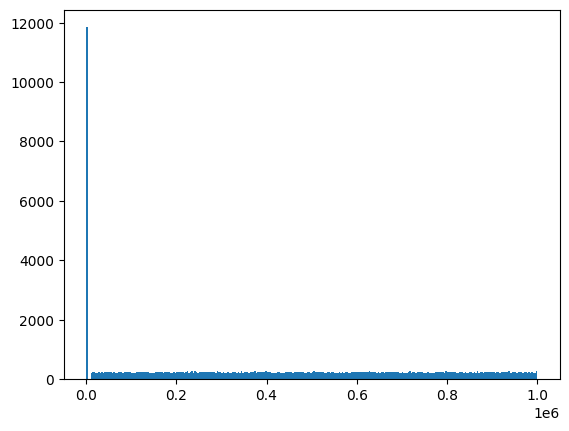

In [61]:
# plt.hist(Re_all, bins=300)